 # Leukemia using ATSC

In [1]:
library("binom") 
library("evaluomeR")
library("clusterAnalysis")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("reshape2")
library("mclust")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

In [2]:
getRversion()
packageVersion("clusterAnalysis")

[1] '4.4.1'

[1] '0.0.0.9000'

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("BrainTumor200.RData")
dataset = BrainTumor200
head(dataset)
unique(dataset$Description)
set.seed(13626)

,Description,X224588_at,X201909_at,X229012_at,X210033_s_at,X236448_at,X240065_at,X206018_at,X225165_at,X220156_at,⋯,X206306_at,X203649_s_at,X206785_s_at,X1563933_a_at,X238603_at,X205751_at,X210271_at,X228347_at,X232720_at,X209138_x_at
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1214834,ependymoma,1.678130,3.644194,3.820705,3.735552,1.172587,3.624207,1.794471,3.691314,3.589067,⋯,3.596530,1.873599,2.146811,3.110174,1.524128,2.563318,1.450476,1.880268,1.737017,1.776431
GSM1214835,ependymoma,3.767506,1.667500,3.224272,3.566060,3.134809,3.381327,3.608933,3.828011,3.315655,⋯,1.716341,1.825732,2.149566,1.619617,1.601342,2.726899,2.637962,1.991922,1.788192,2.720051
GSM1214836,ependymoma,1.676252,3.747256,3.456146,3.642242,1.194883,3.520656,1.797164,3.463318,3.227379,⋯,3.431167,2.897142,2.983751,1.608201,1.587031,2.585998,1.449467,1.815894,1.748981,1.783816
GSM1214837,ependymoma,3.792194,1.636888,3.823623,3.786311,1.168471,3.498731,3.818550,2.747462,3.578139,⋯,1.943356,1.839781,2.128098,1.537581,3.151399,3.113747,1.424955,1.906251,3.647694,2.645952
GSM1214838,ependymoma,3.809949,1.639904,3.561411,1.590063,2.933787,2.997341,1.648297,3.624553,3.551927,⋯,3.594693,2.148758,2.130709,3.167416,1.614435,1.762541,1.429500,1.849851,1.719865,1.758591
GSM1214839,ependymoma,1.740624,3.700109,3.893310,3.761085,1.288353,3.745520,1.841266,3.714091,3.746951,⋯,3.263901,1.930619,2.309651,1.871377,1.540925,1.773522,1.461576,1.901027,1.799332,1.794916


[1] "ependymoma"            "glioblastoma"          "medulloblastoma"      
[4] "pilocytic astrocytoma"

In [4]:
level_mapping <- c("ependymoma" = 1, "glioblastoma" = 2, "medulloblastoma" = 3, "pilocytic astrocytoma" = 4)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(dataset["Description"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
[112] 4 4 4 4 4 4

# Clest <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [5]:
dataset_matrix = as.matrix(dataset[, -1])
clest_result = clusterAnalysis::clest(dataset_matrix, maxK=10, pmax=0.05, dmin=0.05, B=20,B0=20,
                                  clusterAlg=myPam, rho=2/3, similarity=dendextend::FM_index_R, verbose=FALSE)
message(paste0("Clest optimal k: ", clest_result$kopt))

Clest optimal k: 3



In [6]:
pa = cluster::pam(dataset_matrix, clest_result$kopt)
predicted = pa$clustering

In [7]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix = dataset %>% select(-Cluster)
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 27



In [8]:
unique(dataset$Description)

[1] "ependymoma"            "glioblastoma"          "medulloblastoma"      
[4] "pilocytic astrocytoma"

In [9]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = Description,
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "ependymoma" ~ 16,
      Letter == "glioblastoma" ~ 17,
      Letter == "medulloblastoma" ~ 18,
      Letter == "pilocytic astrocytoma" ~ 21,
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)

In [10]:
head(pca_df)

,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,⋯,Dim.21,Dim.22,Dim.23,Dim.24,Dim.25,Dim.26,Dim.27,Cluster,Letter,GoldStandard
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>
GSM1214834,ependymoma,12.561918,-1.4641986,0.7363418,1.3471069,-2.8638011,-2.945067,-1.50084831,-0.1384718,2.474080,⋯,0.3586742,-0.3270069,-0.3504206,-0.9995957,2.087732,0.4515039,0.5587252,1,ependymoma,16
GSM1214835,ependymoma,4.133018,-3.3395813,-4.9842313,4.1161621,0.2925451,4.182317,2.24060108,1.0249558,-4.200720,⋯,0.5669432,-1.8163583,2.3322845,1.0674445,0.900603,-0.1814810,-0.1456840,1,ependymoma,16
GSM1214836,ependymoma,7.241202,1.9148566,1.7250275,-2.1822013,1.1753469,-1.152468,1.24981063,-0.8871428,-1.118430,⋯,0.2224675,1.5492335,-0.9281582,-1.0931953,-1.200774,-0.1911772,2.7884355,1,ependymoma,16
GSM1214837,ependymoma,7.639513,-1.6037920,-3.2939010,5.8350876,-0.3011314,-0.775895,-2.08000573,1.0912472,2.182143,⋯,-1.7855834,1.1636987,0.7131167,0.1006414,-2.156778,0.8665074,0.6691529,1,ependymoma,16
GSM1214838,ependymoma,8.618313,-0.5650169,-1.5441642,0.7943312,-0.1227440,-4.378847,-2.27634499,4.3092283,1.345921,⋯,0.6152089,-1.6733168,0.9503782,0.4330811,-0.622364,-0.3962576,1.5274511,1,ependymoma,16
GSM1214839,ependymoma,11.888910,-0.4046745,1.8045015,1.0152492,-3.2656727,-2.618910,-0.03348363,0.9154421,1.884249,⋯,1.7754717,0.4433422,-0.1961921,0.3610509,1.203225,-1.1983024,-0.2017694,1,ependymoma,16


Warning message:
"The following aesthetics were dropped during statistical transformation: shape
and label.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"ggrepel: 113 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


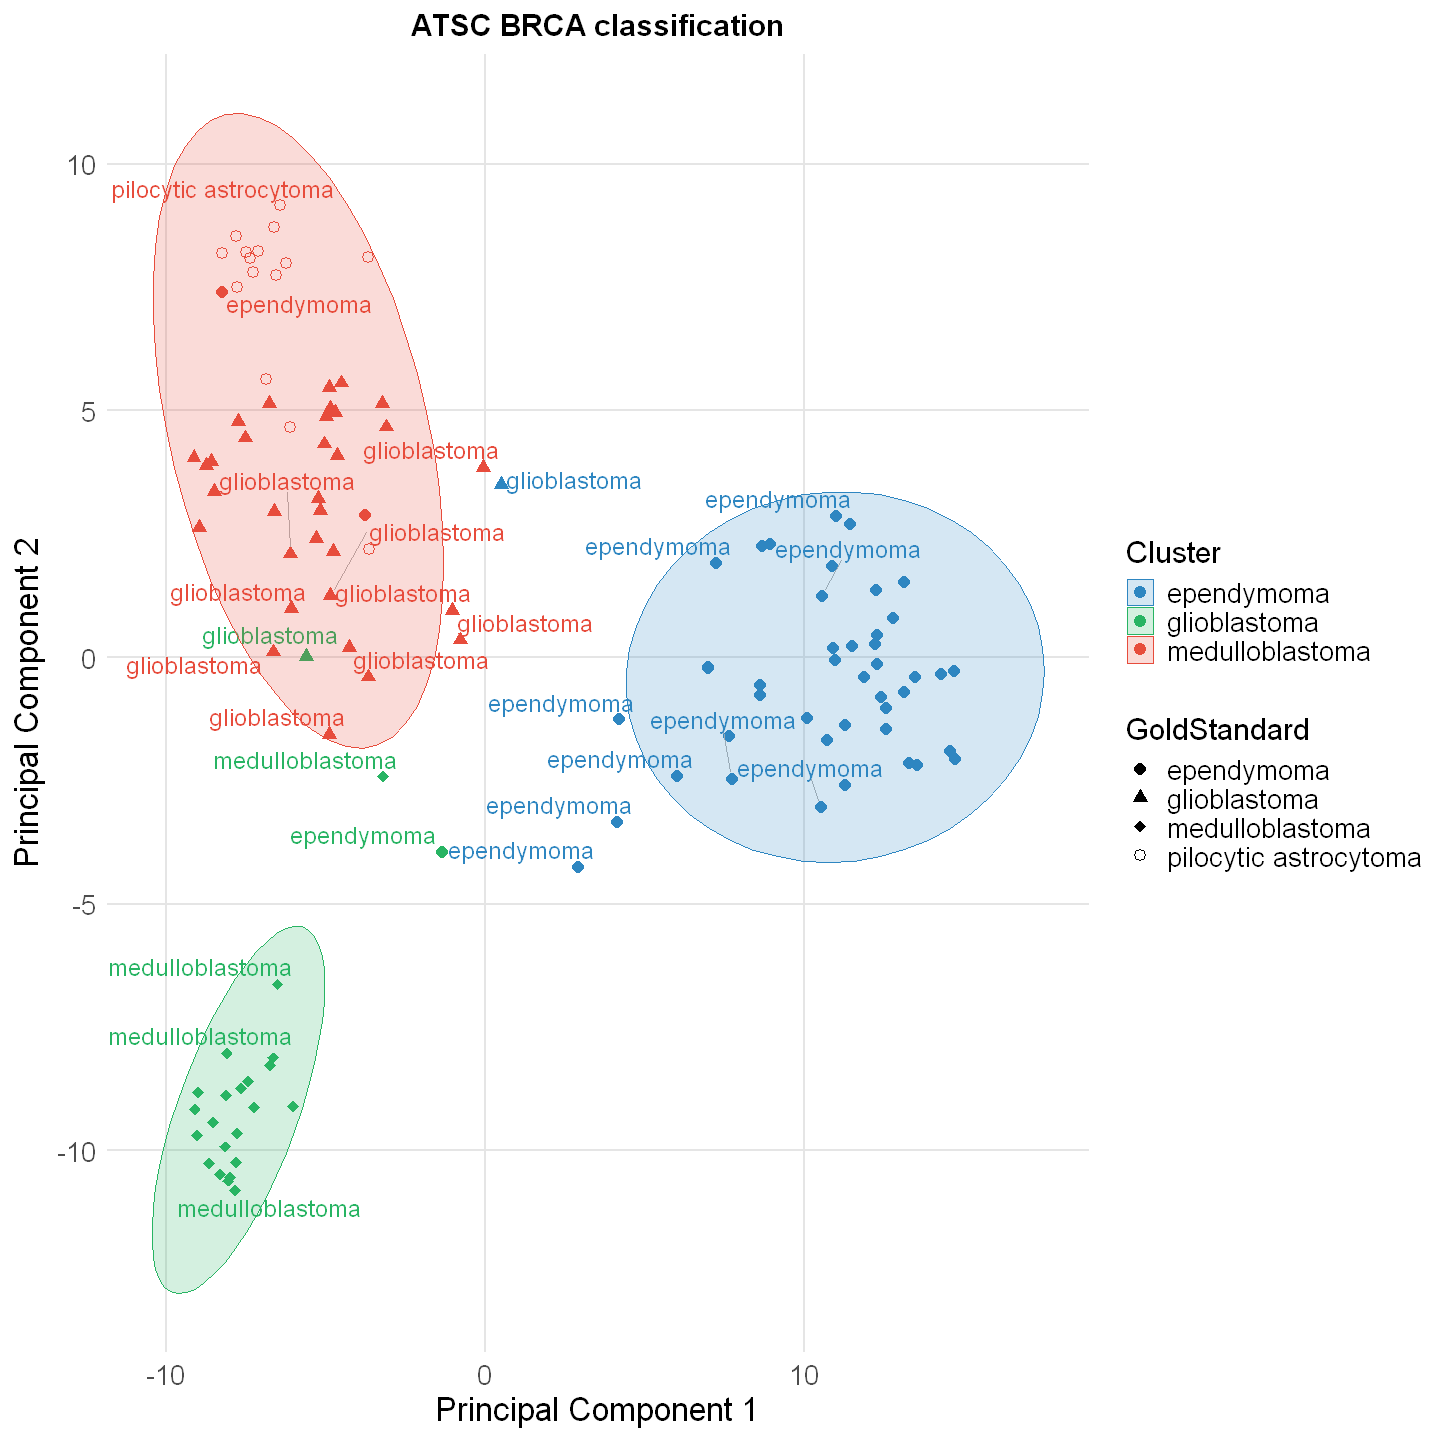

In [11]:
cluster_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D", 
            "#D35400", "#8E44AD", "#16A085")

cluster_shapes = c(16, 17, 18, 21, 22, 23, 24)
cluster_labels = unique(dataset$Description)

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 5,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster, group = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "ATSC BRCA classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = unique(pca_df$Description)) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels)  +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels)   +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

In [12]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
names(sensitivity_table) = cluster_labels
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,ependymoma,glioblastoma,medulloblastoma,pilocytic astrocytoma
,<chr>,<chr>,<chr>,<chr>
Sensitivity. (%),93,94,100,100


[1] "(93,94,100,100)"

In [13]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 12.64%"


In [14]:
clest_result

$p
[1] 0 0 0 0 0 0 0 0 0

$d
[1] 0.4055859 0.4889124 0.3246425 0.3621025 0.3601633 0.3343455 0.3533652
[8] 0.3948373 0.3785055

$kopt
[1] 3

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


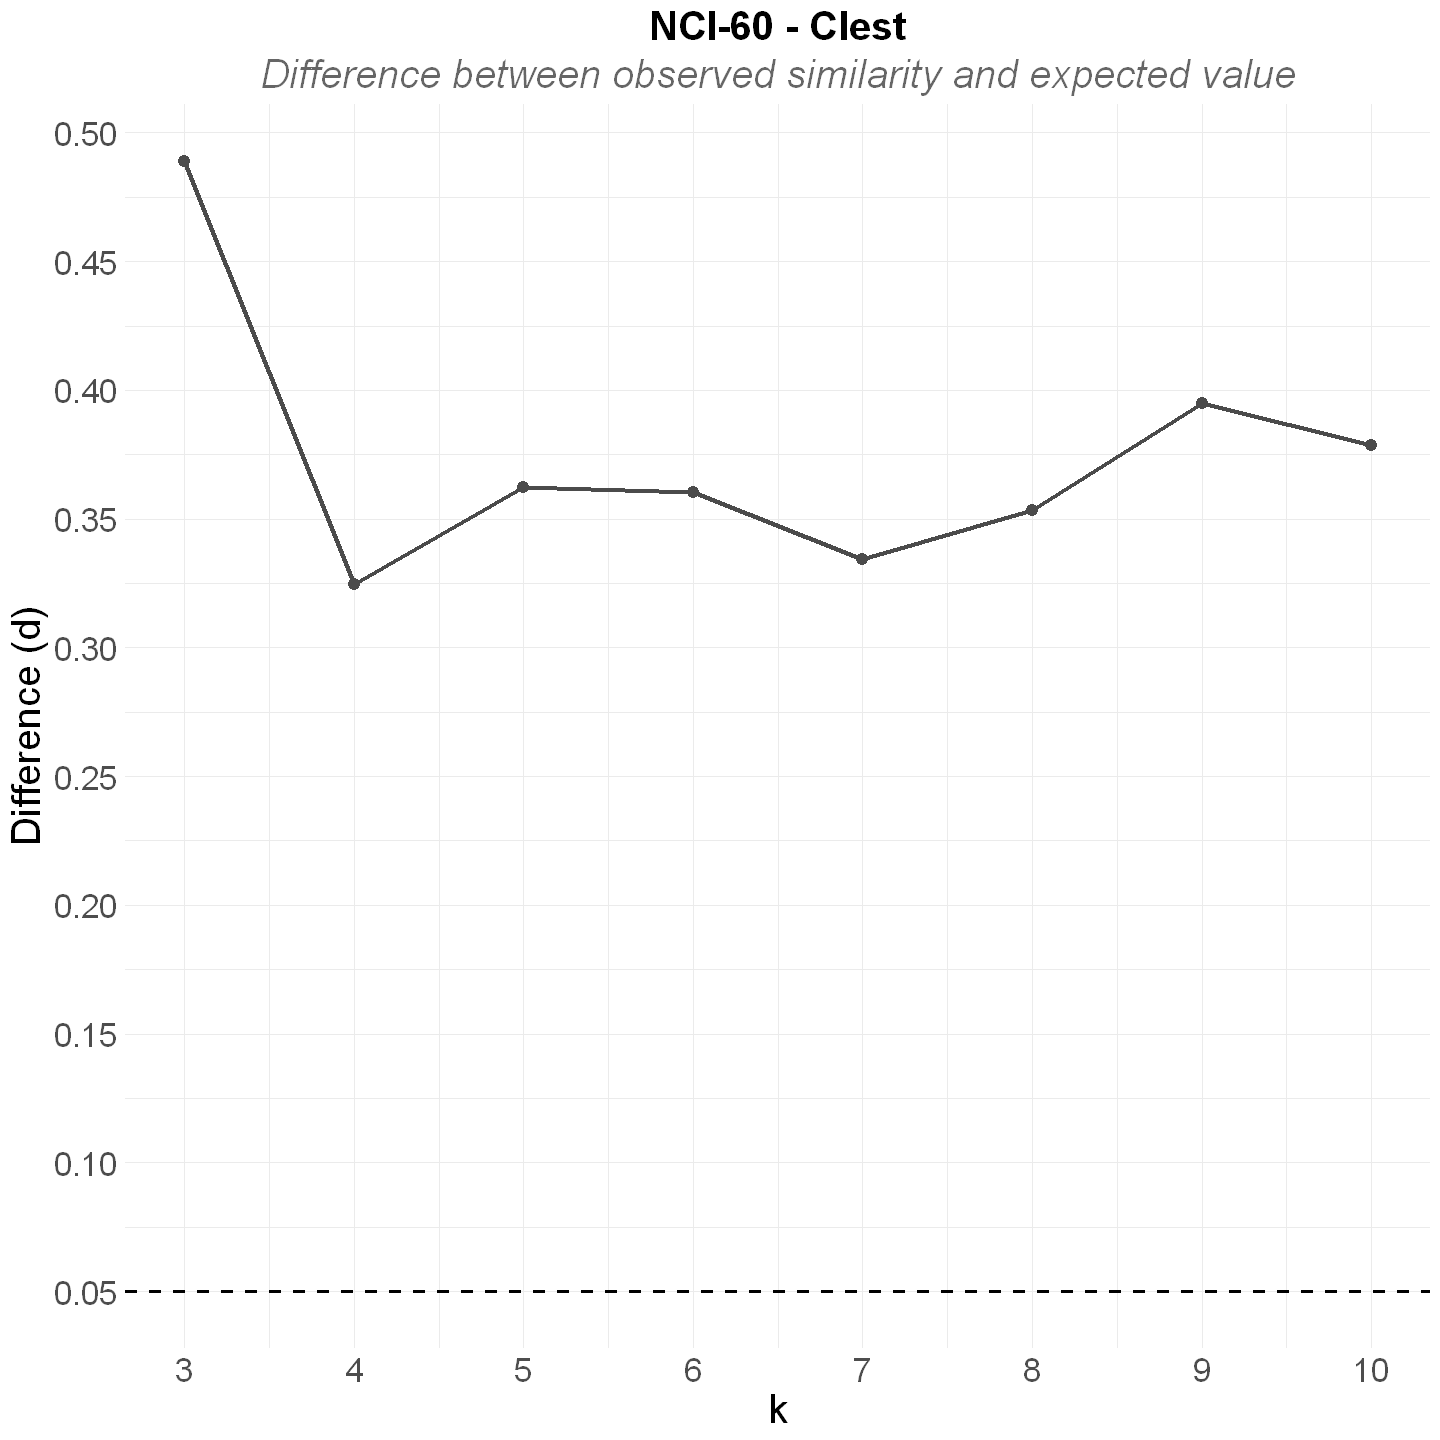

In [15]:
df <- data.frame(K = c(2:10), 
                 Difference = clest_result$d)

ggplot(df, aes(x = K, y = Difference)) +
  geom_line(color = "#4B4B4B", size = 1.2) +
  geom_point(size = 3, color = "#4B4B4B") +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "black", size = 1) +
  scale_y_continuous(breaks = seq(0, max(df$Difference) + 0.05, by = 0.05)) +
  scale_x_continuous(
    limits = c(3, max(df$K)),
    breaks = seq(3, max(df$K), by = 1)
  ) +
  labs(title = "NCI-60 - Clest",
       subtitle = "Difference between observed similarity and expected value",
       x = "k", 
       y = "Difference (d)") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 24, face = "italic", color = "gray40"),
    legend.position = "right",
    legend.title = element_text(size = 24),
    legend.text = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    axis.text = element_text(size = 20)
  )